# 0.0 Business Problem

## Estágio do projeto:
Ciclo 1: Pipeline de dados funcional de ponta a ponta, desde a coleta dos dados até o treinamento do modelo.

## 0.1 Cenário: 
O B7 Bar é um Snooker Bar localizado no Brasil, no estado de São Paulo e atua no setor de bares e restaurantes. Os principais produtos/serviços do B7 Snooker Bar são: aluguel de mesas de bilhar para utilização no local e venda de comidas e bebidas para consumo no local ou delivery.

A empresa conta com um time de colaboradores efetivos, o time está sempre compatível com a demanda ao longo do tempo. Além dos colaboradores efetivos, o bar também contrata colaboradores freelancers, para equilibrar a forte sazonalidade semanal, típica do setor de bares. O equilíbrio entre contratação de colaboradores freelancers e a demanda, é o tema secundário deste projeto.

Apesar da contratação de freelancers, em alguns dias, a demanda supera a disponibilidade de mão de obra. O excesso de demanda gera uma fila de entregas de produtos, principalmente na cozinha, gerando insatisfação para os clientes, perda de qualidade percebida, e além disso, parte da demanda deixa de ser suprida. Os clientes estavam dispostos a consumir mais, portanto a empresa deixou de faturar. 

O bar recebe feedbacks de clientes sobre sua qualidade percebida através das redes sociais e outras ferramentas de qualificação interna. Com base nos feedbacks dos clientes, administração do bar fez um estudo interno, e encomendou um projeto de Data Science para fazer predições de vendas, para fazer uma contratação mais eficiente e atender melhor a necessidade dos clientes. Foram determinadas as seguintes premissas:
1. Ás sextas, sábados e vésperas de feriados, estamos com um time disponível suficiente para atender de forma satisfátória um faturamento de até 3 mil reais.
2. Nos dias que restam, estamos com um time disponível para atender satisfatoriamente um faturamento de até 1 mil e 300 reais.

Através de um estudo interno, a administração deduziu que:
1. Quando o faturamento supera os valores assumidos nas premissas, a empresa deixa de lucrar uma média de 400 reais, pelo não atendimento total da demanda, já abatendo o custo da mão de obra adicional.
2. Por outro lado, a contratação de mão de obra ociosa, ou seja, quando contrata-se mão de obra adicional desnecessariamente, há um custo para a empresa de 300 reais.. A empresa já utiliza um sistema de predições atualmente que tem uma precisão de X%, e um recall de x%, para os casos de predições positivas.

Por motivo de sigilo, foram omitidos do dataset, 12 produtos que são considerados estratégicos para a empresa. Os faturamentos de tais produtos foram totalmente desconsiderados, os valores das premissas foram estipulados já considerando tal diferença de faturamento. Este fato pode ser totalmente ignorado para a elaboração do projeto.

A empresa B7 é um bar, e como todo bar, nos referimos ao valor total consumido pela mesa como "Comanda". Este termo irá se repetir bastante durante o projeto. Os dados são reais, coletados entre 02/01/2018 e 20/03/2020.

## 0.2 Premissas:
1. ...

## 0.3 Estratégia da Solução:

###### 0.3.1 Objetivos:
1. Principais insights sobre as features mais importantes para o faturamento.
2. Quanto de retorno financeiro anual a empresa terá ao utilizar o modelo de predições?
3. Qual será o faturamente total semanal imediatamente seguinte ao dataset? Qual será o faturamento total semanal dos produtos agregados por Classe 1?

###### 0.3.2 Proposta de Solução:

###### 0.3.3 Inputs:

###### 0.3.4 Outputs:


## 0.4 Sumário:

## 0.5 Resultados e Conclusão:

## 0.6 Significado das Features:

###### 0.6.1 bilhar:
1. No: ID da mesa aberta no sistema, é a 'key' da comanda do cliente no sistema, uma vêz que a comanda se encerra, este número nunca mais se repete.
2. Name: Número da mesa física no ambiente de atendimento.
3. Start Time: Horário de início da abertura da comanda do cliente.
4. In use: Tempo em que a comanda permaneceu aberta (tempo em uso no sistema).
5. Semana: Semana relativa do mês, a semana se inicia no dia 1, independente do dia semanal.
6. Turno: Os turnos são divididos em dois. 'Tarde': do início do expediente, até às 21 horas, 'Noite': das 21 horas até o término das atividades. O turno é definido de acordo com o horário de abertura da comanda.
7. Total Bilhar: Total pago de bilhar por comanda.
8. Pago: Valor total pago pela comanda, engloba os produtos consumidos e o aluguel do bilhar.
9. Preço/Hora: Custo do bilhar por hora. O bilhar é cobrado por hora e não por partida (ficha). Os preços podem variar de acordo com dias de semana, promoções e tamanho de mesa de bilhar (A casa conta com mesas de bilhar de tamanho oficial, semi-oficial, oficial americana, e universitárias.
10. Data: Data do início da abertura da comanda.

###### 0.6.2 produtos:
1. Time: Horário da venda do ítem.
2. Purchaser: Mesa física em que o produto foi servido.
3. Item: Nome do produto
4. Voucher: ID da mesa aberta no sistema, é a 'key' da comanda do cliente no sistema, uma vêz que a comanda se encerra, este número nunca mais se repete
5. Name: Número da mesa física no ambiente de atendimento.
6. Semana: Semana relativa do mês, a semana se inicia no dia 1, independente do dia semanal.
7. Turno: Os turnos são divididos em dois. 'Tarde': do início do expediente, até às 21 horas, 'Noite': das 21 horas até o término das atividades. O turno é definido de acordo com a abertura da comanda.
8. Classe 1: Classificação dos produtos segundo a sua natureza de consumo, diretamente relacionado aos setores, diferencia cozinha, bar, bilhar e etc.
9. Classe 2: Classificação dos produtos de acordo com o tipo de insumo que pode ou não ser necessário para sua manipulação, útil para identificar custos diretos. Exemplo: Porções quentes quase sempre são fritas, portanto utilizam gordura vegetal para o seu processamento. Interessante para poder trabalhar melhor a gestão de custos.
10. Classe 3: Classificação dos produtos de acordo com o nicho de clientes que atende, diferencia por exemplo cervejas Mainstream, Premium ou artesanais. Interessante para poder trabalhar melhor os direcionamentos de ações para melhorar as vendas.

# 1.0 Imports

###### 1.1 Importing libraries

In [141]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

import time

import re

tempo_agora = time.time() # Tempo inicial

###### 1.2 Loading datasets

In [2]:
billiard = pd.read_csv('C:\\Users\\Samoel\\My Drive\\Pessoal\\Projetos\\bar_sales_forecast\\bar_sales_forecast\\billiard.csv')
sales = pd.read_csv('C:\\Users\\Samoel\\My Drive\\Pessoal\\Projetos\\bar_sales_forecast\\bar_sales_forecast\\sales.csv')
climate = pd.read_csv('C:\\Users\\Samoel\\My Drive\\Pessoal\\Projetos\\bar_sales_forecast\\bar_sales_forecast\\climate.csv')

###### 1.3 Helper Functions

# 2.0 Data Description and Data Cleaning

## 2.1 Billiard

### 2.1.1 General Analysis

###### 2.1.1.1 Looking dataset

In [3]:
billiard.head(5)

,Unnamed: 0,Unnamed: 0.1,Data,#No,Name,#Start Time,In Use,Semana,Turno,Total Bilhar,Pago,#Preço/Hora
0,0,0,2019-01-02,20405,Guest(40),2/17:17,8:10,1,Tarde,0.0,26.50,0.0
1,1,1,2019-01-02,20406,Mesa 3,2/18:30,1:01,1,Tarde,8.0,8.00,8.0
2,2,2,2019-01-02,20407,Mesa 9,2/19:12,0:48,1,Tarde,6.5,6.50,8.0
3,3,3,2019-01-02,20408,Mesa 4,2/19:31,1:07,1,Tarde,8.0,76.20,8.0
4,4,4,2019-01-02,20409,Mesa 2,2/19:45,3:12,1,Tarde,15.5,80.01,8.0


###### 2.1.1.2 Check NaN values

In [4]:
billiard[billiard.isnull()].sum()

Unnamed: 0      0.0
Unnamed: 0.1    0.0
Data              0
#No             0.0
Name              0
#Start Time       0
In Use            0
Semana          0.0
Turno             0
Total Bilhar    0.0
Pago            0.0
#Preço/Hora     0.0
dtype: object

###### 2.1.1.3 Data types

In [5]:
billiard.dtypes

Unnamed: 0        int64
Unnamed: 0.1      int64
Data             object
#No               int64
Name             object
#Start Time      object
In Use           object
Semana            int64
Turno            object
Total Bilhar    float64
Pago            float64
#Preço/Hora     float64
dtype: object

###### 2.1.1.4 Data dimensions

In [6]:
print(f'Qty of rows: {billiard.shape[0]}')
print(f'Qty of columns: {billiard.shape[0]}')

Qty of rows: 14015
Qty of columns: 14015


### 2.1.2 Data Cleaning

###### 2.1.2.1 Adjusting #Start Time to datetimeindex format

In [7]:
billiard['start_time'] = billiard['#Start Time'].apply(lambda x: x.split('/')[1])

###### 2.1.2.2 Adjusting #Data to datetime format

In [8]:
billiard['Data'] = billiard['Data'].str.replace('/', '-').str.strip()

###### 2.1.2.3 Creating datetime feature with datetime dtype

In [9]:
billiard['datetime'] = billiard['Data'] + '-' + billiard['start_time']
billiard['datetime'] = pd.to_datetime(billiard['datetime'])

###### 2.1.2.4 Changing interesting feature names

In [10]:
billiard.rename(columns={'#No':'id'}, inplace=True)
billiard.rename(columns={'Name':'purchaser'}, inplace=True)
billiard.rename(columns={'Total Bilhar':'sale'}, inplace=True)
billiard.rename(columns={'#Preço/Hora':'price'}, inplace=True)
billiard.rename(columns={'Semana':'week'}, inplace=True)
billiard.rename(columns={'Turno':'work_shift'}, inplace=True)
billiard.rename(columns={'In Use':'in_use'}, inplace=True)

###### 2.1.2.5 Creating quantity feature

In [11]:
billiard['quantity'] = round(billiard['sale'] / billiard['price'], 1)

###### 2.1.2.6 Creating item feature

In [12]:
billiard['item'] = 'bilhar'

###### 2.1.2.7 Droping features

In [13]:
billiard.drop(['Pago', 'Data', 'start_time', '#Start Time'], axis=1, inplace=True)

## 2.2 Sales

### 2.2.1 General Analysis

###### 2.2.1.1 Looking dataset

In [14]:
sales.head(5)

,#Time,Purchaser,Item,#Voucher,Semana,Turno,Classe 1,Classe 2,Classe 3,Preço,Total Venda,Data,Quantidade
0,3/00:47:08,Guest(37),Caips 2,20425,1,Noite,Bar,Drink,NaN,13.0,13.0,1/2/2019,1
1,2/22:58:30,Mesa 5,1500,20417,1,Noite,Bar,Cerveja,Mainstream,8.7,8.7,1/2/2019,1
2,2/23:02:40,Mesa 1,1500,20415,1,Noite,Bar,Cerveja,Mainstream,8.7,8.7,1/2/2019,1
3,2/19:32:10,Mesa 4,Agua c/ Gás,20408,1,Tarde,Bar,Sem Álcool,NaN,3.5,7.0,1/2/2019,2
4,2/22:49:33,Guest(25),Agua c/ Gás,20413,1,Noite,Bar,Sem Álcool,NaN,3.5,3.5,1/2/2019,1


###### 2.2.1.2 Check NaN's values

In [15]:
sales.isnull().sum()

#Time              0
Purchaser       3157
Item               0
#Voucher           0
Semana             0
Turno              0
Classe 1           0
Classe 2        3736
Classe 3       20103
Preço              0
Total Venda        0
Data               0
Quantidade         0
dtype: int64

O sistema gestor de vendas utilizado tem uma modalidade de vendas que não vincula o produto à uma mesa de consumo, geralmente utilizados quando ocorre uma venda avulsa, que é paga no ato da compra. Tais produtos são inseridos no sistema sem informação no campo "Purchaser", o que justifica os 8930 NaN Values nessa feature. As features Classe 2 e Classe 3 possuem NaN Values porque alguns produtos são cadastrados e classificados apenas no primeiro nível (Classe 1).

###### 2.2.1.3 Data dimensions

In [16]:
print(f'Quantity of {sales.shape[0]} rows')
print(f'Quantity of {sales.shape[1]} columns')

Quantity of 34209 rows
Quantity of 13 columns


###### 2.2.1.4 Data types

In [17]:
sales.dtypes

#Time           object
Purchaser       object
Item            object
#Voucher         int64
Semana           int64
Turno           object
Classe 1        object
Classe 2        object
Classe 3        object
Preço          float64
Total Venda    float64
Data            object
Quantidade       int64
dtype: object

### 2.2.2 Data Cleaning

###### 2.1.2.1 Catch date informations

In [18]:
sales['Time'] = sales['#Time'].apply(lambda x: x.split('/')[1])
sales['datetime'] = sales['Data'] + '-' + sales['Time']

###### 2.1.2.2 Creating datetime feature

In [19]:
sales['datetime'] = pd.to_datetime(sales['datetime'])

###### 2.1.2.3 Changing interesting feature names

In [20]:
sales.rename(columns={'#Voucher':'id'}, inplace=True)
sales.rename(columns={'Total Venda':'sale'}, inplace=True)
sales.rename(columns={'Preço':'price'}, inplace=True)
sales.rename(columns={'Classe 1':'class1'}, inplace=True)
sales.rename(columns={'Semana':'week'}, inplace=True)
sales.rename(columns={'Turno':'work_shift'}, inplace=True)
sales.rename(columns={'Purchaser':'purchaser'}, inplace=True)
sales.rename(columns={'Item':'item'}, inplace=True)
sales.rename(columns={'Quantidade':'quantity'}, inplace=True)

###### 2.1.2.4 Removing features

In [21]:
sales.drop(['#Time', 'Data', 'Time', 'Classe 2', 'Classe 3'], axis=1, inplace=True)

## 2.3 Climate

### 2.3.1 General Analysis

###### 2.3.1.1 Looking dataframe

In [22]:
climate.head(5)

,Data,Temperatura mínima diária,Temperatura máxima diária,Vento constante máximo,Rajada de vento máxima,Precipitação diária total,Espessura de neve,Pressão,Ícone,Descrição
0,1/1/2019,22°C,31°C,21 Km/h,NaN,NaN,NaN,NaN,NaN,Chuva
1,2/1/2019,22°C,33°C,24 Km/h,42 Km/h,0mm,NaN,NaN,NaN,Tempestade de raios
2,3/1/2019,22°C,33°C,22 Km/h,NaN,0mm,NaN,NaN,NaN,eventos climáticos não informados
3,4/1/2019,22°C,27°C,22 Km/h,NaN,NaN,NaN,NaN,NaN,Tempestade de raios
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Chuva


###### 2.3.1.2 Data dimensions

In [23]:
print(f'Quantity of rows: {climate.shape[0]}')
print(f'Quantity of columns: {climate.shape[1]}')

Quantity of rows: 529
Quantity of columns: 10


###### 2.3.1.3 Check NaN values

In [24]:
climate.isnull().sum()

Data                          95
Temperatura mínima diária     96
Temperatura máxima diária     96
Vento constante máximo       162
Rajada de vento máxima       497
Precipitação diária total    250
Espessura de neve            529
Pressão                      529
Ícone                        529
Descrição                      0
dtype: int64

### 2.3.2 Data Cleaning

###### 2.3.2.1 Removing rows where date is null

In [25]:
climate = climate[climate['Data'].notnull()]

###### 2.3.2.2 Removing units of measure

In [26]:
climate.loc[climate['Temperatura mínima diária'].notnull(), 'Temperatura mínima diária'] = climate['Temperatura mínima diária'].dropna().apply(lambda x: re.findall('\d*', x)[0])
climate.loc[climate['Temperatura máxima diária'].notnull(), 'Temperatura máxima diária'] = climate['Temperatura máxima diária'].dropna().apply(lambda x: re.findall('\d*', x)[0])
climate.loc[climate['Vento constante máximo'].notnull(), 'Vento constante máximo'] = climate['Vento constante máximo'].dropna().apply(lambda x: re.findall('\d*', x)[0])
climate.loc[climate['Precipitação diária total'].notnull(), 'Precipitação diária total'] = climate['Precipitação diária total'].dropna().apply(lambda x: re.findall('\d*', x)[0])

###### 2.3.2.3 Adjusting datetime feature

In [27]:
climate.rename(columns={'Data': 'date'}, inplace=True)

climate['date'] = pd.to_datetime(climate['date']).dt.date
climate['date'] = pd.to_datetime(climate['date'])

climate.set_index('date', inplace=True)

###### 2.3.2.4 Removing some features

In [28]:
climate.drop(['Espessura de neve', 'Pressão', 'Ícone', 'Rajada de vento máxima'], axis=1, inplace=True)

## 2.4 Concating Dataframes

###### 2.4.1 Concating billiard and sales

In [29]:
df = pd.concat([billiard, sales], axis=0)

###### 2.4.2 Pivoting table to date x class1

In [30]:
backup = df.copy()

In [31]:
df = backup.copy()

df.loc[df['class1'].isnull(), 'class1'] = 'Bilhar'

In [32]:
df['datetime'] = pd.to_datetime(df['datetime'])
df['date'] = df['datetime'].dt.date
df['date'] = pd.to_datetime(df['date'])

In [33]:
df = df.pivot_table(columns='class1', index='date', values='sale', aggfunc='sum', fill_value=0)

###### 2.4.3 Removing "#N/D" feature

In [34]:
df.loc[df['#N/D'] != 0, '#N/D'].count()

1

In [35]:
df.drop('#N/D', axis=1, inplace=True)

###### 2.4.4 Concating df and climate

In [36]:
backup = df.copy()

In [37]:
df = backup.copy()

df = df.merge(climate, on='date', how='left')

## 2.5 Integral Dataframe

###### 2.4.1 Looking dataframe

In [38]:
df.sample(5)

,Bar,Bilhar,Bomboniere,Cozinha,Gorjeta,Tabacaria,Temperatura mínima diária,Temperatura máxima diária,Vento constante máximo,Precipitação diária total,Descrição
date,,,,,,,,,,,
2019-11-28,573.51,226.5,0.0,173.5,35.4,1.51,21,30,24,NaN,Chuva
2019-06-22,1040.84,346.0,11.0,251.4,55.4,47.00,14,27,15,0,eventos climáticos não informados
2019-02-02,1346.75,372.9,2.0,304.9,61.4,34.50,21,36,15,NaN,Tempestade de raios
2019-03-23,1584.77,470.5,6.0,620.1,78.3,88.00,19,29,15,0,eventos climáticos não informados
2019-01-03,320.12,123.0,2.5,64.7,10.6,33.00,22,27,22,NaN,Tempestade de raios


###### 2.4.2 Data dimensions

In [39]:
print(f'Number of rows: {df.shape[0]}')
print(f'Number of columns: {df.shape[1]}')

Number of rows: 378
Number of columns: 11


###### 2.4.3 Check NaN values

In [40]:
df.isnull().sum()

Bar                            0
Bilhar                         0
Bomboniere                     0
Cozinha                        0
Gorjeta                        0
Tabacaria                      0
Temperatura mínima diária     33
Temperatura máxima diária     33
Vento constante máximo        85
Precipitação diária total    153
Descrição                     32
dtype: int64

<AxesSubplot:ylabel='date'>

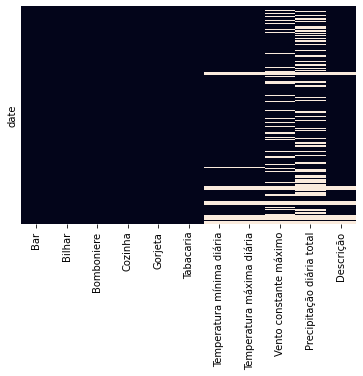

In [41]:
sns.heatmap(df.isnull(), yticklabels=False, cbar=False)

###### 2.4.4 Solving business day frequency

In [42]:
date_ = pd.date_range(start='2019-01-02', end='2020-03-20', freq='d')

In [43]:
df = df.resample('d').sum()

###### 2.4.5 Create total

In [56]:
df['total'] = df.sum(axis=1)

## 2.5 Descriptive Statistics

# 3.0 Feature Engineering

### 2.4.2 Data Cleaning

###### 2.4.2.1 Removing columns with to much NaN values

# 4.0 Business Hypothesis

# 5.0 Exploratory Data Analysis 

# 6.0 Data Preparation

###### 6.1 Amostral Space

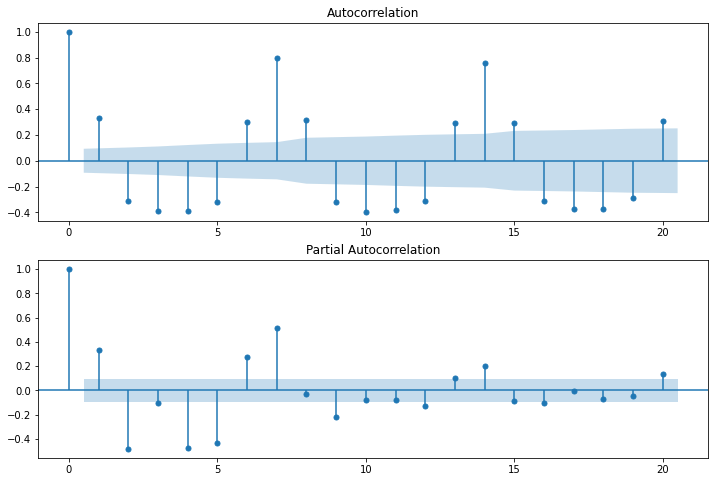

In [66]:
fig = plt.figure(figsize=(12, 8))
ax1 = fig.add_subplot(211)
fig = plot_acf(df['total'] , lags=20, ax=ax1)
ax2 = fig.add_subplot(212)
fig = plot_pacf(df['total'] , lags=20, ax=ax2)

###### 6.2 train and test

In [74]:
X = df.iloc[:344]

In [75]:
y = df.iloc[344:]

# 7.0 Training ML Model

## 7.1 ARIMA

In [108]:
arima_model = ARIMA(endog=X['total'], order=(7, 7, 7))

arima_fit = arima_model.fit()

print(arima_fit.summary())

In [111]:
arima_pred = res.predict(start='2019-12-12', end='2020-03-20')

C:\Users\Samoel\My Drive\Pessoal\Projetos\environments\data_science\lib\site-packages\statsmodels\tsa\base\tsa_model.py:132: FutureWarning: The 'freq' argument in Timestamp is deprecated and will be removed in a future version.
  date_key = Timestamp(key, freq=base_index.freq)


In [112]:
y['predicts'] = arima_pred

C:\Users\Samoel\AppData\Local\Temp/ipykernel_11996/847852269.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  y['predicts'] = arima_pred


<AxesSubplot:xlabel='date'>

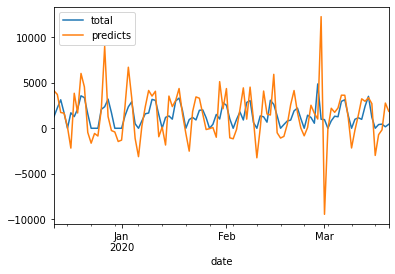

In [115]:
y[['total', 'predicts']].plot()

In [119]:
y['square_error'] = (y['total'] - y['predicts']) ** 2

C:\Users\Samoel\AppData\Local\Temp/ipykernel_11996/2818592425.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  y['square_error'] = (y['total'] - y['predicts']) ** 2


In [120]:
y['absolut_error'] = np.sqrt(y['square_error'])

C:\Users\Samoel\AppData\Local\Temp/ipykernel_11996/2656420322.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  y['absolut_error'] = np.sqrt(y['square_error'])


**MAE**

In [122]:
y['absolut_error'].mean()

1674.7064627871578

**MAPE**

In [130]:
y.loc[y['total'] == 0, 'total'] = 10 ** -6

C:\Users\Samoel\My Drive\Pessoal\Projetos\environments\data_science\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\Samoel\My Drive\Pessoal\Projetos\environments\data_science\lib\site-packages\pandas\core\indexing.py:723: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value, self.name)


# 8.0 Results and Conclusions

# Time

In [9]:
print(f'O projeto está processando em {round((time.time() - tempo_agora) / 60, 2)} minutos')

O projeto está processando em 2.17 minutos


# Continua